In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import os
from IPython import display
os.chdir('..')
import data
os.chdir('notebooks')

ModuleNotFoundError: No module named 'data'

In [14]:
import shutil
#shutil.rmtree('octa/pred_mean//')

In [4]:
z_dim = 128
batch = 128
max_step = 50001
summary_step = 100

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self._net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        self.mean_fc = nn.Linear(128, 2)
        self.var_fc = nn.Linear(128, 2)
    
    def forward(self, z):
        h = self._net(z)
        return self.mean_fc(h), self.var_fc(h)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self._net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self._net(x)

In [6]:
device = torch.device("cuda:0")

# Read Data

In [15]:
def generate_data():
    num_data = 50000
    noise_std = 0.1
    radius = 1
    rad = np.random.choice([
        0, np.pi / 4, np.pi / 2, 3 * np.pi / 4,
        np.pi, 5 * np.pi / 4, 3 * np.pi / 2, 7 * np.pi / 4
    ], [num_data])
    data = np.stack([radius * np.cos(rad), radius * np.sin(rad)], axis=1)
    noise = np.random.normal(0, noise_std, data.shape)
    return data + noise
    
raw_data = generate_data()
dataset = torch.utils.data.TensorDataset(torch.Tensor(raw_data))
dataset.vector_preprocess = lambda x: x
#data_iterator = data.DataIterator(dataset, batch_size=batch, sampler=data.InfiniteRandomSampler(dataset))

In [20]:
raw_data

array([[ 0.12963152, -1.1354435 ],
       [-0.0690444 ,  0.87052675],
       [-0.05483682,  1.04465169],
       ...,
       [ 0.87101206, -0.1739673 ],
       [-0.7568259 ,  0.72366955],
       [ 1.09713994,  0.14930306]])

# Visualize the Data

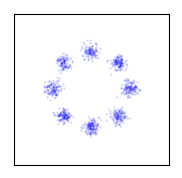

In [18]:
vis_limit = 2.0

def visualize_samples(samples, save_path=None):
    fig = plt.figure(figsize=(2,2), dpi=100)
    plt.plot(samples[:,0], samples[:,1], 'b.', markersize=1, alpha=0.2)
    axes = plt.gca()
    axes.set_xlim([-vis_limit, vis_limit])
    axes.set_ylim([-vis_limit, vis_limit])
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0)

    return fig

grid_size = 64
grid = np.tile(np.reshape(np.linspace(-vis_limit, vis_limit, grid_size), (grid_size, 1)), (1, grid_size))
coord = np.stack([np.transpose(grid), grid], axis=2)
coord = coord[::-1, :]
coord = np.reshape(coord, [grid_size ** 2, 2])
coord = torch.Tensor(coord).to(device)

def visualize_discriminator(d):
    with torch.no_grad():
        verdicts = d(coord).cpu().numpy()
    verdicts = np.reshape(verdicts, [grid_size, grid_size])
    fig = plt.figure(figsize=(2,2), dpi=100)
    plt.imshow(verdicts)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return fig

fig = visualize_samples(raw_data[:1000], save_path='octa/data.png')

# Train GAN

In [19]:
G = Generator().to(device)
D = Discriminator().to(device)
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
criterion = nn.BCELoss()
real_label = 1
fake_label = 0
summary_step = 10

# Train
training_loss_sum = 0.0
for step in range(summary_step * 200):
    # Train D
    x = next(data_iterator).to(device)
    z = torch.normal(torch.zeros((x.size(0), z_dim)),
                     torch.ones((x.size(0), z_dim))).to(device)

    D.zero_grad()
    label = torch.full((x.size(0),), real_label, device=device)
    fake, _ = G(z)
    real_loss = criterion(D(x), label)
    real_loss.backward()

    label.fill_(fake_label)
    fake_loss = criterion(D(fake.detach()), label)
    fake_loss.backward()
    D_optimizer.step()

    # Train G
    G.zero_grad()
    label.fill_(real_label)
    G_loss = criterion(D(fake), label)
    G_loss.backward()
    G_optimizer.step()

    # Summary
    if step % 10 == 0:
        with torch.no_grad():
            z = torch.normal(torch.zeros((1000, z_dim)), 1.0).to(device)
            samples, _ = G(z)
            samples = samples.cpu().numpy()
        display.clear_output(wait=True)
        print("Step %d" % step)
        fig = visualize_samples(samples, 'octa/gan/%07d.png' % step)

        # Visualize D's view
        visualize_discriminator(D)


NameError: name 'data_iterator' is not defined

# Train Gaussian Predictor

In [ ]:
P_gaussian = Generator().to(device)
P_optimizer = torch.optim.Adam(P_gaussian.parameters(), lr=0.0001)
mse_loss = nn.MSELoss()
summary_step = 50  # for MM
summary_step = 5

# Train
training_loss_sum = 0.0
for step in range(summary_step * 200):
    # Train G
    x = next(data_iterator).to(device)
    z = torch.normal(torch.zeros((x.size(0), z_dim)),
                     torch.ones((x.size(0), z_dim))).to(device)
    P_gaussian.zero_grad()
    mean, log_var = P_gaussian(z)
    P_loss = ((mean - x) ** 2) / (2 * torch.exp(log_var)) + log_var / 2
    P_loss.sum(dim=1).mean(dim=0).backward()
    P_optimizer.step()

    # Summary
    if step % summary_step == 0:
        with torch.no_grad():
            z = torch.normal(torch.zeros((1000, z_dim)), 1.0).to(device)
            mean, log_var = P_gaussian(z)
            samples = torch.normal(mean.repeat(2, 1), log_var.exp().sqrt().repeat(2, 1))
            mean = mean.cpu().numpy()
            samples = samples.cpu().numpy()
        display.clear_output(wait=True)
        print("Step %d" % step)
        fig = visualize_samples(mean, 'octa/gaussian_pred_mean/%07d.png' % step)
        fig = visualize_samples(samples, 'octa/gaussian_pred/%07d.png' % step)


# Train Laplace Predictor

In [ ]:
P_laplace = Generator().to(device)
P_optimizer = torch.optim.Adam(P_laplace.parameters(), lr=0.0001)
mse_loss = nn.MSELoss()
summary_step = 50  # for MM
summary_step = 5

# Train
training_loss_sum = 0.0
for step in range(summary_step * 200):
    # Train G
    x = next(data_iterator).to(device)
    z = torch.normal(torch.zeros((x.size(0), z_dim)),
                     torch.ones((x.size(0), z_dim))).to(device)
    P_laplace.zero_grad()
    mean, log_var = P_laplace(z)
    P_loss = (mean - x).abs() / torch.exp(log_var) + log_var
    P_loss.sum(dim=1).mean(dim=0).backward()
    P_optimizer.step()

    # Summary
    if step % summary_step == 0:
        with torch.no_grad():
            z = torch.normal(torch.zeros((1000, z_dim)), 1.0).to(device)
            mean, log_var = P_laplace(z)
            laplace = torch.distributions.laplace.Laplace(mean.repeat(2, 1), log_var.exp().repeat(2, 1))
            samples = laplace.sample()
            mean = mean.cpu().numpy()
            samples = samples.cpu().numpy()
        display.clear_output(wait=True)
        print("Step %d" % step)
        fig = visualize_samples(mean, 'octa/laplace_pred_median/%07d.png' % step)
        fig = visualize_samples(samples, 'octa/laplace_pred/%07d.png' % step)


# Train GAN with L2 Loss

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
criterion = nn.BCELoss()
real_label = 1
fake_label = 0
summary_step = 10

# Train
training_loss_sum = 0.0
for step in range(summary_step * 200):
    # Train D
    x = next(data_iterator).to(device)
    z = torch.normal(torch.zeros((x.size(0), z_dim)),
                     torch.ones((x.size(0), z_dim))).to(device)

    D.zero_grad()
    label = torch.full((x.size(0),), real_label, device=device)
    fake, _ = G(z)
    real_loss = criterion(D(x), label)
    real_loss.backward()

    label.fill_(fake_label)
    fake_loss = criterion(D(fake.detach()), label)
    fake_loss.backward()
    D_optimizer.step()

    # Train G
    G.zero_grad()
    label.fill_(real_label)
    G_loss = criterion(D(fake), label)
    l2_loss = mse_loss(fake, x)
    (G_loss + l2_loss).backward()
    G_optimizer.step()

    # Summary
    if step % summary_step == 0:
        with torch.no_grad():
            z = torch.normal(torch.zeros((1000, z_dim)), 1.0).to(device)
            samples, _ = G(z)
            samples = samples.cpu().numpy()
        display.clear_output(wait=True)
        print("[Step %d] L2 Loss: %.3f | GAN Loss: %.3f" % (step, l2_loss, G_loss))
        fig = visualize_samples(samples, 'octa/gan+l2/%07d.png' % step)
        fig = visualize_discriminator(D)

# Train GAN with Gaussian Moment Matching

In [10]:
def train_harmony(method, dist, order):
    G = Generator().to(device)
    D = Discriminator().to(device)
    G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
    D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
    criterion = nn.BCELoss()
    real_label = 1
    fake_label = 0
    summary_step = 75

    # Train
    training_loss_sum = 0.0
    for step in range(summary_step * 200):
        # Train D
        x = next(data_iterator).to(device)
        z = torch.normal(torch.zeros((x.size(0), z_dim)),
                         torch.ones((x.size(0), z_dim))).to(device)

        D.zero_grad()
        label = torch.full((x.size(0),), real_label, device=device)
        fake, _ = G(z)
        real_loss = criterion(D(x), label)
        real_loss.backward()

        label.fill_(fake_label)
        fake_loss = criterion(D(fake.detach()), label)
        fake_loss.backward()
        D_optimizer.step()

        # Train G
        with torch.no_grad():
            p_mean, p_log_var = P(z)
            p_var = torch.exp(p_log_var)
        G.zero_grad()
        label.fill_(real_label)
        G_loss = criterion(D(fake), label)
        gen_mean = fake.mean(dim=0)
        gen_var = fake.std(dim=0) ** 2
        mm_loss = (p_mean[0] - gen_mean) ** 2 + (p_var[0] - gen_var) ** 2
        mm_loss = mm_loss.mean(dim=0)
        (G_loss + mm_loss).backward()
        G_optimizer.step()

        # Summary
        if step % summary_step == 0:
            with torch.no_grad():
                z = torch.normal(torch.zeros((1000, z_dim)), 1.0).to(device)
                samples, _ = G(z)
                samples = samples.cpu().numpy()
            display.clear_output(wait=True)
            print("[Step %d] MM Loss: %.3f | GAN Loss: %.3f" % (step, mm_loss, G_loss))
            fig = visualize_samples(samples, 'octa/mm/%07d.png' % step)
            fig = visualize_discriminator(D)


# Train GAN with L1 Loss

In [11]:
G = Generator().to(device)
D = Discriminator().to(device)
G_optimizer = torch.optim.SGD(G.parameters(), lr=0.001)
D_optimizer = torch.optim.SGD(D.parameters(), lr=0.001)
criterion = nn.BCELoss()
real_label = 1
fake_label = 0
# Train
training_loss_sum = 0.0
for step in range(max_step):
    # Train D
    x = next(data_iterator).to(device)
    z = torch.normal(torch.zeros((x.size(0), z_dim)),
                     torch.ones((x.size(0), z_dim))).to(device)

    D.zero_grad()
    label = torch.full((x.size(0),), real_label, device=device)
    fake, _ = G(z)
    real_loss = criterion(D(x), label)
    real_loss.backward()

    label.fill_(fake_label)
    fake_loss = criterion(D(fake.detach()), label)
    fake_loss.backward()
    D_optimizer.step()

    # Train G
    G.zero_grad()
    label.fill_(real_label)
    G_loss = criterion(D(fake), label)
    l1_loss = (fake - x).abs().mean()
    (G_loss + l1_loss).backward()
    G_optimizer.step()

    # Summary
    if step % summary_step == 0:
        with torch.no_grad():
            z = torch.normal(torch.zeros((1000, z_dim)), 1.0).to(device)
            samples, _ = G(z)
            samples = samples.cpu().numpy()
        display.clear_output(wait=True)
        print("[Step %d] L1 Loss: %.3f | GAN Loss: %.3f" % (step, l1_loss, G_loss))
        os.makedirs('notebooks/toy_data_summary/gan+l1', exist_ok=True)
        fig = visualize_samples(samples)
        fig.savefig('notebooks/toy_data_summary/gan+l1/%07d.pdf' % step, bbox_inches='tight', pad_inches=0)

        # Visualize D's view
        fig = visualize_discriminator(D)
        fig.savefig('notebooks/toy_data_summary/gan+l1/d_%07d.pdf' % step, bbox_inches='tight', pad_inches=0)


NameError: name 'data_iterator' is not defined

# Train Laplace Predictor

In [12]:
P_laplace = Generator().to(device)
P_optimizer = torch.optim.SGD(P_laplace.parameters(), lr=0.001)
mse_loss = nn.MSELoss()
# Train
training_loss_sum = 0.0
for step in range(max_step):
    # Train G
    x = next(data_iterator).to(device)
    z = torch.normal(torch.zeros((x.size(0), z_dim)),
                     torch.ones((x.size(0), z_dim))).to(device)
    P_laplace.zero_grad()
    mean, log_var = P_laplace(z)
    P_loss = (mean - x).abs() / torch.exp(log_var) + log_var
    P_loss.sum(dim=1).mean(dim=0).backward()
    P_optimizer.step()

    # Summary
    if step % summary_step == 0:
        with torch.no_grad():
            z = torch.normal(torch.zeros((1000, z_dim)), 1.0).to(device)
            mean, log_var = P_laplace(z)
            dist = torch.distributions.Laplace(mean, log_var.exp())
            samples = dist.sample()
            mean = mean.cpu().numpy()
            samples = samples.cpu().numpy()
        display.clear_output(wait=True)
        print("Step %d" % step)
        os.makedirs('notebooks/toy_data_summary/predictor_laplace_median', exist_ok=True)
        fig = visualize_samples(mean)
        fig.savefig('notebooks/toy_data_summary/predictor_laplace_median/%07d.pdf' % step, bbox_inches='tight', pad_inches=0)
        fig = visualize_samples(samples)
        fig.savefig('notebooks/toy_data_summary/predictor_laplace_sample/%07d.pdf' % step, bbox_inches='tight', pad_inches=0)


NameError: name 'data_iterator' is not defined

# Train GAN with Laplace Moment Matching

In [13]:
G = Generator().to(device)
D = Discriminator().to(device)
G_optimizer = torch.optim.SGD(G.parameters(), lr=0.001)
D_optimizer = torch.optim.SGD(D.parameters(), lr=0.001)
criterion = nn.BCELoss()
real_label = 1
fake_label = 0

# Train
training_loss_sum = 0.0
for step in range(max_step * 5):
    # Train D
    x = next(data_iterator).to(device)
    z = torch.normal(torch.zeros((x.size(0), z_dim)),
                     torch.ones((x.size(0), z_dim))).to(device)

    D.zero_grad()
    label = torch.full((x.size(0),), real_label, device=device)
    fake, _ = G(z)
    real_loss = criterion(D(x), label)
    real_loss.backward()

    label.fill_(fake_label)
    fake_loss = criterion(D(fake.detach()), label)
    fake_loss.backward()
    D_optimizer.step()

    # Train G
    with torch.no_grad():
        p_mean, p_log_var = P_laplace(z)
        p_var = torch.exp(p_log_var)
    G.zero_grad()
    label.fill_(real_label)
    G_loss = criterion(D(fake), label)
    gen_median = fake.median(dim=0, keepdim=True)[0]
    gen_mad = (fake - gen_median).abs().mean(0)
    gen_median = gen_median.squeeze(0)
    mm_loss = (p_mean[0] - gen_median) ** 2 + (p_var[0] - gen_mad) ** 2
    mm_loss = mm_loss.mean(dim=0)
    (G_loss + mm_loss).backward()
    G_optimizer.step()

    # Summary
    if step % summary_step == 0:
        with torch.no_grad():
            z = torch.normal(torch.zeros((1000, z_dim)), 1.0).to(device)
            samples, _ = G(z)
            samples = samples.cpu().numpy()
        display.clear_output(wait=True)
        print("[Step %d] MM Loss: %.3f | GAN Loss: %.3f" % (step, mm_loss, G_loss))
        fig = visualize_samples(samples)
        os.makedirs('notebooks/toy_data_summary/gan+laplace_mm', exist_ok=True)
        fig.savefig('notebooks/toy_data_summary/gan+laplace_mm/%07d.pdf' % step, bbox_inches='tight', pad_inches=0)

        # Visualize D's view
        fig = visualize_discriminator(D)
        fig.savefig('notebooks/toy_data_summary/gan+laplace_mm/d_%07d.pdf' % step, bbox_inches='tight', pad_inches=0)


NameError: name 'data_iterator' is not defined